In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
#df_yelp = pd.read_csv("yelp_small.csv")

In [4]:
#df_yelp=df_yelp.set_index("Unnamed: 0")

In [5]:
#df_yelp=df_yelp.rename(columns={"Consumer_complaint_narrative":"review","category_id":"label"})

In [6]:
#df = df_yelp.sample(frac=1)

In [7]:
#df.head()

In [8]:
# numbers=list(df['label'].unique())
# list_zeros = [0]*5
# count_dictionary = dict(zip(numbers, list_zeros))

# values_array_train=[]
# values_array_test=[]
# values_array_unlabelled=[]
# for index, row in df.iterrows():
#     if count_dictionary[row['label']]<20:
#         count_dictionary[row['label']]=count_dictionary[row['label']]+1
#         values_array_train.append((row['review'],row['label']))
#     elif count_dictionary[row['label']]<60:
#         count_dictionary[row['label']]=count_dictionary[row['label']]+1
#         values_array_test.append((row['review'],row['label']))
#     elif count_dictionary[row['label']]<600:
#         count_dictionary[row['label']]=count_dictionary[row['label']]+1
#         values_array_unlabelled.append((row['review'],'UNK'))

In [9]:
df_train_l=pd.read_csv("assigned/train_l.csv", index_col="Unnamed: 0")
df_test_l=pd.read_csv("assigned/test_l.csv", index_col="Unnamed: 0")
df_u=pd.read_csv("assigned/u.csv", index_col="Unnamed: 0")
df_train_u=pd.read_csv("assigned/train_u.csv", index_col="Unnamed: 0")
df_test_u=pd.read_csv("assigned/test_u.csv", index_col="Unnamed: 0")

In [10]:
df_train_l.head()

,0,1
0,Huge gender imbalance and rude staff.,1
1,Didn't come here to eat just drink but can't r...,3
2,Nova's is great if you get their fresh bread....,4
3,I got coconut shaved ice with condensed milk a...,5
4,Very nice octogenarian who was wholly unable t...,2


In [11]:
values_array_train=list(df_train_l.to_records(index=False))
values_array_test=list(df_test_l.to_records(index=False))
values_array_unlabelled=df_u.to_records(index=False)

In [12]:
print(len(values_array_train))

100


In [13]:
print(len(values_array_test))

200


In [14]:
print(len(values_array_unlabelled))

5000


In [15]:
print(values_array_test)

[('I love Starbucks coffee.  My new favorite is the blonde roast.  This location gets pretty crowded, especially on Friday mornings.  The baristas here are really friendly.', 5), ('This place is so good I have never had bad food or service. The owner Kevin makes sure you leave happy. The pizza and wings are the best any were.', 5), ('i came in as a tourist in the early afternoon with friends. The local folks were having a great time. We got the full tourist tour by the bartender, she was patient and made some great drinks. Love Tiki and this bar was fun!!', 5), ('Roasted chicken with apricot glaze was perfect! Perfectly moist with delicious flavor.', 5), ('Great Pizza & service. Will go back', 4), ('My favorite! I love that they use plastic protectors for the pedicure tubs. I love the massage chairs. The staff is always friendly & welcoming. My pedicure lasts & lasts. Mona is the best!', 5), ('Had a flat and went to a Big O Tires to get it fix. Front desk manager Pat was great and repl

In [16]:
#!pip install transformers==4.3.2
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install sentencepiece

##Set random values
#seed_val = 42
seed_val = 4
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [17]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1080 Ti


In [18]:
#--------------------------------
#  Transformer parameters
#--------------------------------
max_seq_length = 64
batch_size = 92

#--------------------------------
#  GAN-BERT specific parameters
#--------------------------------
# number of hidden layers in the generator, 
# each of the size of the output space
num_hidden_layers_g = 1; 
# number of hidden layers in the discriminator, 
# each of the size of the input space
num_hidden_layers_d = 1; 
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
apply_balance = True

#--------------------------------
#  Optimization parameters
#--------------------------------
learning_rate_discriminator = 5e-6
#learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 400
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------
#  Adopted Tranformer model
#--------------------------------
# Since this version is compatible with Huggingface transformers, you can uncomment
# (or add) transformer models compatible with GAN


#model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
#model_name = "amazon/bort"
#model_name="google/electra-large-discriminator"
#model_name="google/electra-small-discriminator"
#model_name="microsoft/deberta-v2-xxlarge"
#model_name="microsoft/deberta-v3-base"
model_name = "google/electra-base-discriminator"

#--------------------------------
#  Retrieve the TREC QC Dataset
#--------------------------------
#! git clone https://github.com/crux82/ganbert

#  NOTE: in this setting 50 classes are involved
# labeled_file = "./ganbert/data/labeled.tsv"
# unlabeled_file = "./ganbert/data/unlabeled.tsv"
# test_filename = "./ganbert/data/test.tsv"

label_list = ['UNK',1,2,3,4,5]

In [19]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file https://huggingface.co/google/electra-base-discriminator/resolve/main/config.json from cache at /home/harry/.cache/huggingface/transformers/7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.57c13443a51769ce892714c93bb3ee3952bad66d7d9662d9de382b808377c3f8
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transform

In [20]:
#Load the examples
labeled_examples = values_array_train
#unlabeled_examples = values_array_unlabelled
test_examples = values_array_test

In [21]:
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are 
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples  
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask: 
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples): 
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATE A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))
  
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)
  
  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]                          
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), 
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)
#If unlabel examples are available
# if unlabeled_examples:
#   train_examples = train_examples + unlabeled_examples
#   #The unlabeled (train) dataset is assigned with a mask set to False
#   tmp_masks = np.zeros(len(unlabeled_examples), dtype=bool)
#   train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

In [23]:
#------------------------------
#   The Generator as in 
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
# class Generator(nn.Module):
#     def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
#         super(Generator, self).__init__()
#         layers = []
#         hidden_sizes = [noise_size] + hidden_sizes
#         for i in range(len(hidden_sizes)-1):
#             layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

#         layers.append(nn.Linear(hidden_sizes[-1],output_size))
#         self.layers = nn.Sequential(*layers)

#     def forward(self, noise):
#         output_rep = self.layers(noise)
#         return output_rep

#------------------------------
#   The Discriminator
#   https://www.aclweb.org/anthology/2020.acl-main.191/
#   https://github.com/crux82/ganbert
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [24]:
# The config file is required to get the dimension of the vector produced by 
# the underlying transformer
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)
# Define the number and width of hidden layers
#hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
#generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():    
  #generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

loading configuration file https://huggingface.co/google/electra-base-discriminator/resolve/main/config.json from cache at /home/harry/.cache/huggingface/transformers/7d1569a4df2372d67341bda716bce4e3edf3e3ffadb97251bc4b6b35d459f624.57c13443a51769ce892714c93bb3ee3952bad66d7d9662d9de382b808377c3f8
Model config ElectraConfig {
  "_name_or_path": "google/electra-base-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transform

In [25]:
training_stats = []

accuracy_array=[]

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
#g_vars = [v for v in generator.parameters()]

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
#gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
#   scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
#                                            num_warmup_steps = num_warmup_steps)

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    transformer.train() 
    #generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)

        real_batch_size = b_input_ids.shape[0]
     
        # Encode real data in the Transformer
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs.last_hidden_state[:,0,:]
        #hidden_states = model_outputs[-1]
        #print(hidden_states[0].size())
        
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer. 
        # First noisy input are used in input to the Generator
        #noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
        # Gnerate Fake data
        #gen_rep = generator(noise)
        #print("Length of generator output {}".format(len(gen_rep)))
        #print("Length of single generator output {}".format(len(gen_rep[0])))

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        #disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(hidden_states)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, real_batch_size)
        D_real_features = features_list[0]
        #D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, real_batch_size)
        D_real_logits = logits_list[0]
        #D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, real_batch_size)
        D_real_probs = probs_list[0]
        #D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
#         g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
#         g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
#         g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        #D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U #+ D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        #gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        #g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        #gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        #tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()
        
        _, preds = torch.max(logits[:,0:-1], 1)
        #print(preds)

        # Update the learning rate with the scheduler
        if apply_scheduler:
          scheduler_d.step()
          #scheduler_g.step()

    # Calculate the average loss over all of the batches.
    #avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    #print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    discriminator.eval()
    #generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            #hidden_states = model_outputs[-1]
            hidden_states = model_outputs.last_hidden_state[:,0,:]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()
        #print(preds)

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            #'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )
    
    accuracy_array.append(test_accuracy)


======== Epoch 1 / 400 ========
Training...

  Average training loss discriminator: 2.013
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.105
  Test Loss: 1.796
  Test took: 0:00:00

======== Epoch 2 / 400 ========
Training...

  Average training loss discriminator: 1.988
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.145
  Test Loss: 1.790
  Test took: 0:00:00

======== Epoch 3 / 400 ========
Training...

  Average training loss discriminator: 1.924
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.190
  Test Loss: 1.785
  Test took: 0:00:00

======== Epoch 4 / 400 ========
Training...

  Average training loss discriminator: 1.935
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.220
  Test Loss: 1.779
  Test took: 0:00:00

======== Epoch 5 / 400 ========
Training...

  Average training loss discriminator: 1.930
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.225
  Test Loss: 1.774
  Test took: 0:00:00

======== Epoch

  Accuracy: 0.305
  Test Loss: 1.644
  Test took: 0:00:00

======== Epoch 43 / 400 ========
Training...

  Average training loss discriminator: 1.665
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.310
  Test Loss: 1.641
  Test took: 0:00:00

======== Epoch 44 / 400 ========
Training...

  Average training loss discriminator: 1.650
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.305
  Test Loss: 1.639
  Test took: 0:00:00

======== Epoch 45 / 400 ========
Training...

  Average training loss discriminator: 1.669
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.320
  Test Loss: 1.636
  Test took: 0:00:00

======== Epoch 46 / 400 ========
Training...

  Average training loss discriminator: 1.643
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.310
  Test Loss: 1.634
  Test took: 0:00:00

======== Epoch 47 / 400 ========
Training...

  Average training loss discriminator: 1.643
  Training epcoh took: 0:00:01

Running Test...
  Accuracy


  Average training loss discriminator: 1.328
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.440
  Test Loss: 1.501
  Test took: 0:00:00

======== Epoch 85 / 400 ========
Training...

  Average training loss discriminator: 1.329
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.415
  Test Loss: 1.497
  Test took: 0:00:00

======== Epoch 86 / 400 ========
Training...

  Average training loss discriminator: 1.362
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.400
  Test Loss: 1.495
  Test took: 0:00:00

======== Epoch 87 / 400 ========
Training...

  Average training loss discriminator: 1.298
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.405
  Test Loss: 1.492
  Test took: 0:00:00

======== Epoch 88 / 400 ========
Training...

  Average training loss discriminator: 1.276
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.425
  Test Loss: 1.486
  Test took: 0:00:00

======== Epoch 89 / 400 ========
Training...

  Average

  Accuracy: 0.490
  Test Loss: 1.289
  Test took: 0:00:00

======== Epoch 126 / 400 ========
Training...

  Average training loss discriminator: 0.775
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.495
  Test Loss: 1.289
  Test took: 0:00:00

======== Epoch 127 / 400 ========
Training...

  Average training loss discriminator: 0.828
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.490
  Test Loss: 1.284
  Test took: 0:00:00

======== Epoch 128 / 400 ========
Training...

  Average training loss discriminator: 0.799
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.485
  Test Loss: 1.273
  Test took: 0:00:00

======== Epoch 129 / 400 ========
Training...

  Average training loss discriminator: 0.714
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.475
  Test Loss: 1.263
  Test took: 0:00:00

======== Epoch 130 / 400 ========
Training...

  Average training loss discriminator: 0.708
  Training epcoh took: 0:00:01

Running Test...
  Acc


  Average training loss discriminator: 0.384
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.475
  Test Loss: 1.199
  Test took: 0:00:00

======== Epoch 168 / 400 ========
Training...

  Average training loss discriminator: 0.348
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.510
  Test Loss: 1.195
  Test took: 0:00:00

======== Epoch 169 / 400 ========
Training...

  Average training loss discriminator: 0.359
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.510
  Test Loss: 1.193
  Test took: 0:00:00

======== Epoch 170 / 400 ========
Training...

  Average training loss discriminator: 0.346
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.510
  Test Loss: 1.189
  Test took: 0:00:00

======== Epoch 171 / 400 ========
Training...

  Average training loss discriminator: 0.390
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.505
  Test Loss: 1.188
  Test took: 0:00:00

======== Epoch 172 / 400 ========
Training...

  Av

  Accuracy: 0.500
  Test Loss: 1.231
  Test took: 0:00:00

======== Epoch 209 / 400 ========
Training...

  Average training loss discriminator: 0.208
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.495
  Test Loss: 1.235
  Test took: 0:00:00

======== Epoch 210 / 400 ========
Training...

  Average training loss discriminator: 0.206
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.495
  Test Loss: 1.237
  Test took: 0:00:00

======== Epoch 211 / 400 ========
Training...

  Average training loss discriminator: 0.227
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.495
  Test Loss: 1.235
  Test took: 0:00:00

======== Epoch 212 / 400 ========
Training...

  Average training loss discriminator: 0.209
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.485
  Test Loss: 1.235
  Test took: 0:00:00

======== Epoch 213 / 400 ========
Training...

  Average training loss discriminator: 0.198
  Training epcoh took: 0:00:01

Running Test...
  Acc

  Accuracy: 0.495
  Test Loss: 1.430
  Test took: 0:00:00

======== Epoch 317 / 400 ========
Training...

  Average training loss discriminator: 0.088
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.505
  Test Loss: 1.427
  Test took: 0:00:00

======== Epoch 318 / 400 ========
Training...

  Average training loss discriminator: 0.092
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.505
  Test Loss: 1.423
  Test took: 0:00:00

======== Epoch 319 / 400 ========
Training...

  Average training loss discriminator: 0.086
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.510
  Test Loss: 1.419
  Test took: 0:00:00

======== Epoch 320 / 400 ========
Training...

  Average training loss discriminator: 0.088
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.510
  Test Loss: 1.418
  Test took: 0:00:00

======== Epoch 321 / 400 ========
Training...

  Average training loss discriminator: 0.080
  Training epcoh took: 0:00:01

Running Test...
  Acc


  Average training loss discriminator: 0.061
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.490
  Test Loss: 1.495
  Test took: 0:00:00

======== Epoch 359 / 400 ========
Training...

  Average training loss discriminator: 0.072
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.490
  Test Loss: 1.500
  Test took: 0:00:00

======== Epoch 360 / 400 ========
Training...

  Average training loss discriminator: 0.072
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.500
  Test Loss: 1.503
  Test took: 0:00:00

======== Epoch 361 / 400 ========
Training...

  Average training loss discriminator: 0.059
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.505
  Test Loss: 1.503
  Test took: 0:00:00

======== Epoch 362 / 400 ========
Training...

  Average training loss discriminator: 0.070
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.500
  Test Loss: 1.501
  Test took: 0:00:00

======== Epoch 363 / 400 ========
Training...

  Av

  Accuracy: 0.505
  Test Loss: 1.561
  Test took: 0:00:00

======== Epoch 400 / 400 ========
Training...

  Average training loss discriminator: 0.053
  Training epcoh took: 0:00:01

Running Test...
  Accuracy: 0.505
  Test Loss: 1.569
  Test took: 0:00:00


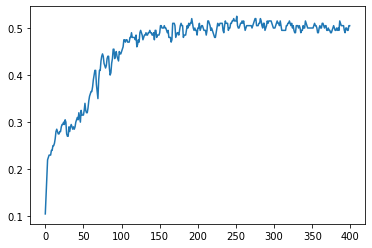

In [26]:
plt.plot(accuracy_array)

In [27]:
max(accuracy_array)

0.525

In [28]:
print(accuracy_array[-1])

0.505
